In [13]:
%pylab inline

from __future__ import division, print_function

import warnings

warnings.filterwarnings('ignore')

import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
import geopandas as gpd
from glob import glob
import holidays
import plotly.graph_objects as go
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.special import boxcox1p
from itertools import product
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [92]:
data = pd.DataFrame()

for filename in glob('data/aggregated_data/*'):
    df = pd.DataFrame(pd.read_pickle(filename))
    data = pd.concat([data, df], axis=0)

# удаляем данные за года, отличные от 2020-2022 (случайные выбросы)
data = data[(data.index >= datetime(2020, 10, 1, 0, 0, 0))
                                                        & (data.index <= datetime(2022, 11, 30, 23, 59, 59))]
data.sort_index(inplace=True)

In [93]:
mean_taxi_trips = pd.DataFrame(data.mean(axis=0), columns=['mean_taxi_trips'])

In [94]:
data.head()

PULocationID,1,3,4,5,6,7,8,9,10,11,...,111,172,199,30,59,245,57,2,110,27
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 02:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print('Количество районов, где более 5 поездок в час - ', mean_taxi_trips[mean_taxi_trips['mean_taxi_trips'] >= 5].shape[0])

Количество районов, где более 5 поездок в час -  55


Будем использовать только те ряды, где больше 5 поездок в час

In [95]:
data = data[mean_taxi_trips[mean_taxi_trips['mean_taxi_trips'] >= 5].index]

## Clustering

In [96]:
# Перед кластеризацией стандартизируем стобцы.
# Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда,
# но не его средний уровень и размах колебаний.

scaler = StandardScaler()
standartized_data = pd.DataFrame(scaler.fit_transform(data))
standartized_data.index = data.index
standartized_data.columns = data.columns

standartized_data = standartized_data.T
standartized_data.head()

tpep_pickup_datetime,2020-10-01 00:00:00,2020-10-01 01:00:00,2020-10-01 02:00:00,2020-10-01 03:00:00,2020-10-01 04:00:00,2020-10-01 05:00:00,2020-10-01 06:00:00,2020-10-01 07:00:00,2020-10-01 08:00:00,2020-10-01 09:00:00,...,2022-11-30 14:00:00,2022-11-30 15:00:00,2022-11-30 16:00:00,2022-11-30 17:00:00,2022-11-30 18:00:00,2022-11-30 19:00:00,2022-11-30 20:00:00,2022-11-30 21:00:00,2022-11-30 22:00:00,2022-11-30 23:00:00
PULocationID,,,,,,,,,,,,,,,,,,,,,
13,-0.974344,-0.974344,-0.974344,-0.974344,-0.921167,-0.921167,-0.974344,-0.708458,-0.761635,-0.176685,...,0.674150,0.727328,0.833682,1.312277,2.109936,2.269467,1.312277,0.674150,-0.229863,-0.442571
24,-1.154847,-1.049079,-1.049079,-1.154847,-1.260614,-1.154847,-0.837544,-0.097170,1.277809,0.748971,...,0.008597,0.537435,1.172041,1.277809,0.960506,-0.202938,-0.308706,-0.202938,-0.308706,-0.202938
41,-1.272950,-1.272950,-1.073779,-1.173365,-1.173365,-1.173365,-0.775024,0.021658,2.013361,0.419998,...,0.121243,-0.277098,-0.177513,-0.277098,0.121243,-0.376683,-0.575853,-0.675439,-0.177513,-0.675439
43,-1.040608,-1.040608,-1.057796,-1.057796,-1.057796,-1.023421,-1.040608,-0.731237,-0.129682,-0.559364,...,0.815619,1.589046,1.124990,0.471873,1.073428,0.746869,0.196876,0.231251,-0.164057,-0.267180
48,-1.332854,-1.271317,-1.363623,-1.486698,-1.532851,-1.455929,-0.686711,-0.209796,-0.271334,-0.794402,...,0.190197,0.051738,0.682496,0.836340,1.559404,1.359408,1.420945,1.328639,1.974782,2.297853


In [111]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

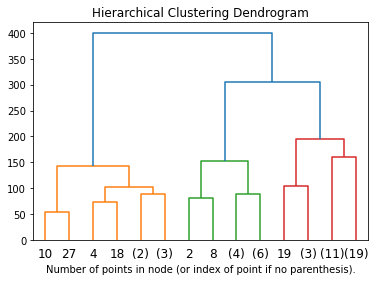

In [98]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(standartized_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [99]:
model = KMeans(n_clusters=3)
model = model.fit(standartized_data)

silhouette_score(standartized_data, model.labels_)

0.19655681559369004

In [100]:
label_0 = [col for col, label in zip(data.columns, model.labels_) if label == 0]

In [ ]:
px.line(standartized_data.T[label_0])

In [102]:
label_1 = [col for col, label in zip(data.columns, model.labels_) if label == 1]

In [ ]:
px.line(standartized_data.T[label_1])

In [104]:
label_2 = [col for col, label in zip(data.columns, model.labels_) if label == 2]

In [ ]:
px.line(standartized_data.T[label_2])

In [117]:
best_cos_sim_0 = 0
for col in label_0:
    cos_sim_0 = cosine_similarity(model.cluster_centers_[0, :].reshape(1, -1), standartized_data.T[col].values.reshape(1, -1))
    if best_cos_sim_0 < cos_sim_0:
        best_cos_sim_0 = cos_sim_0
        best_col_0 = col

best_col_0, best_cos_sim_0

(68, array([[0.96250565]]))

In [119]:
best_cos_sim_1 = 0
for col in label_1:
    cos_sim_1 = cosine_similarity(model.cluster_centers_[1, :].reshape(1, -1), standartized_data.T[col].values.reshape(1, -1))
    if best_cos_sim_1 < cos_sim_1:
        best_cos_sim_1 = cos_sim_1
        best_col_1 = col

best_col_1, best_cos_sim_1

(249, array([[0.95920075]]))

In [120]:
best_cos_sim_2 = 0
for col in label_2:
    cos_sim_2 = cosine_similarity(model.cluster_centers_[2, :].reshape(1, -1), standartized_data.T[col].values.reshape(1, -1))
    if best_cos_sim_2 < cos_sim_2:
        best_cos_sim_2 = cos_sim_2
        best_col_2 = col

best_col_2, best_cos_sim_2

(238, array([[0.97519894]]))

## Добавляем регрессионные признаки и строим ARIMA

Построим для ряда, наиболее близкого к центру кластера, модель ARIMA. Будем использовать ее параметры для всего кластера.

In [142]:
def add_holidays(y):
    holidays_NY = holidays.country_holidays('US', state='NY', years=[2020, 2022])
    holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
    holidays_NY.index = pd.to_datetime(holidays_NY.index)
    holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
    res = pd.DataFrame(np.zeros((y.shape[0], 1)), index=y.index, columns=['holiday'])
    for index, _ in holidays_NY.items():
        for i in range(0, 24):
            index = index.replace(hour = i)
            res.loc[index, 'holiday'] = 1
    return res

def add_feature(indexes, K, seasons = [24, 168, 8766], trend=False):
    res = pd.DataFrame(index=indexes, columns=[i for i in range(2*K*len(seasons))])
    for i, season in enumerate(seasons):
        arr = 2 * np.pi * np.outer(np.arange(1, len(indexes) + 1), np.arange(1, K + 1)) / season
        res.loc[:, 2*K*i: 2*K*i+K - 1] = np.sin(arr)
        res.loc[:, 2*K*i+K:2*K*i+2*K - 1] = np.cos(arr)

        if trend: res.loc[:, 'trend'] = np.arange(1, len(indexes)+1)

    holidays = add_holidays(res)
    res = res.join(holidays, how='left')
    res.drop_duplicates(inplace=True)
    return res

In [122]:
def invboxcox1p(y,lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

In [149]:
_lambda_center_cluster_0 = stats.boxcox(data[data[68] > 0][68])[1]
_lambda_center_cluster_1 = stats.boxcox(data[data[249] > 0][249])[1]
_lambda_center_cluster_2 = stats.boxcox(data[data[238] > 0][238])[1]

In [150]:
box_cox_center_cluster_0 = boxcox1p(data[68], _lambda_center_cluster_0)
box_cox_center_cluster_1 = boxcox1p(data[249], _lambda_center_cluster_1)
box_cox_center_cluster_2 = boxcox1p(data[238], _lambda_center_cluster_2)

In [151]:
k=5

X_center_cluster = add_feature(box_cox_center_cluster_0.index, k, trend=True)

In [154]:
data_center_clusters = pd.concat([box_cox_center_cluster_0, box_cox_center_cluster_1, box_cox_center_cluster_2,
                                   X_center_cluster], axis=1)

In [155]:
data_center_clusters.head()

,68,249,238,0,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,trend,holiday
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,3.410818,7.571246,4.038973,0.258819,0.5,0.707107,0.866025,0.965926,0.965926,0.866025,...,0.002150,0.002867,0.003584,1.000000,0.999999,0.999998,0.999996,0.999994,1,0.0
2020-10-01 01:00:00,4.847744,4.508517,3.690297,0.5,0.866025,1.0,0.866025,0.5,0.866025,0.5,...,0.004301,0.005734,0.007168,0.999999,0.999996,0.999991,0.999984,0.999974,2,0.0
2020-10-01 02:00:00,2.049314,1.909676,2.489050,0.707107,1.0,0.707107,0.0,-0.707107,0.707107,0.0,...,0.006451,0.008601,0.010751,0.999998,0.999991,0.999979,0.999963,0.999942,3,0.0
2020-10-01 03:00:00,2.544240,1.412485,2.489050,0.866025,0.866025,0.0,-0.866025,-0.866025,0.5,-0.5,...,0.008601,0.011468,0.014335,0.999996,0.999984,0.999963,0.999934,0.999897,4,0.0
2020-10-01 04:00:00,1.492014,0.810410,1.470679,0.965926,0.5,-0.707107,-0.866025,0.258819,0.258819,-0.866025,...,0.010751,0.014335,0.017918,0.999994,0.999974,0.999942,0.999897,0.999839,5,0.0


In [156]:
train, test = data_center_clusters[data_center_clusters.index < datetime(2022, 11, 1, 0, 0, 0)], data_center_clusters[data_center_clusters.index >= datetime(2022, 11, 1, 0, 0, 0)]

In [157]:
ps = range(0, 3)
d=0
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [158]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
%%time
warnings.filterwarnings('ignore')

for col in [68, 249, 238]:
    results = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model = sm.tsa.statespace.SARIMAX(train[col],
                                              order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], 24),
                                              trend='t',
                                              exog=train[[i for i in range(10, 30)] + ['holiday']]).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']

    print(f'Номер временного ряда - {col}')

    print('Таблица aic и параметров')
    print()
    print(result_table.sort_values(by = 'aic', ascending=True).head())

    plt.rcParams['figure.figsize'] = 30, 7
    plt.subplot(211)
    best_model.resid[25:].plot()
    plt.ylabel(u'Residuals')

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_acf(best_model.resid[25:].values.squeeze(), lags=48, ax=ax)

    print()
    print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

warnings.filterwarnings('default')

Настроим модели под каждый временной ряд, используя информацию о параметрах, полученную выше. На основе принадлежности ряда к кластеру выбираем параметры.

Одновременно будем предсказывать и замерять качество

In [ ]:
params_0 = (p, q, P, Q)
params_1 = (p, q, P, Q)
params_2 = (p, q, P, Q)

In [ ]:
for col in data.columns:
    if col in label_0:
        param = params_0
    elif col in label_1:
        param = params_1
    elif col in label_2:
        param = params_2

    _lambda = stats.boxcox(data[data[col] > 0][col])[1]
    box_cox = boxcox1p(data[col], _lambda_center_cluster_0)

    box_cox_data = pd.concat([box_cox, X_center_cluster], axis=1)

    train, test = box_cox_data[box_cox_data.index < datetime(2022, 11, 1, 0, 0, 0)], box_cox_data[box_cox_data.index >= datetime(2022, 11, 1, 0, 0, 0)]

    model = sm.tsa.statespace.SARIMAX(train[col],
                                      order=(param[0], d, param[1]),
                                      seasonal_order=(param[2], D, param[3], 24),
                                      trend='t',
                                      exog=train[[i for i in range(10, 30)] + ['holiday']]).fit(disp=-1)

    predict = invboxcox1p(model.predict(start=len(train), end=len(train) + len(test) - 1,
                                   exog=test[[i for i in range(10, 30)] + ['holiday']]), _lambda).values

    # Предсказание почасовое
    print(f'Mean absolute SARIMAX error for {col} = {(test[col].values - predict).abs().mean():.2f}')